In [1]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42
video_path = 'data_generated/R25_gray_scaled.mp4'

video = VideoLoader(video_path, duration=30, gray=True)
meta = {'w': video.width,
        'h': video.height,
        'fps': video.fps,
        'bs': video.batch_size,
        'gray': video.gray}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))
models = torch.load('data_generated/week7/models.pth', map_location=device)

# Convert TempConvAE's weights
d = models['10-TempConvAE']['model']
d["to_lower_rep.weight"] = d["low_dim_mapping.0.weight"]
d["to_lower_rep.bias"] =   d["low_dim_mapping.0.bias"]
d["from_lower_rep.weight"] = d["low_dim_mapping.1.weight"]
d["from_lower_rep.bias"] = d["low_dim_mapping.1.bias"]
del d["low_dim_mapping.0.weight"]
del d["low_dim_mapping.0.bias"]
del d['low_dim_mapping.1.weight']
del d['low_dim_mapping.1.bias']
del models['10-OneHAE']['little_modification']

Device: Tesla P100-PCIE-12GB


## JIGSAWS

Useful variables created:
- `i2act` and `act2i`
- `nact`, `nvideo_per_act[_train, _test]`
- `videos[_train, _test]`
- `video_durations`
- `test_set_indices`

In [ ]:
i2act = {0: 'Knot_Tying',
        1: 'Needle_Passing',
        2: 'Suturing'}
nact = len(i2act.keys())
act2i = {v: k for k, v in i2act.items()}

# Gesture index to description
gi2descr = {
    1: 'Reaching for needle with right hand',
    2: 'Positioning needle',
    3: 'Pushing needle through tissue',
    4: 'Transferring needle from left to right',
    5: 'Moving to center with needle in grip',
    6: 'Pulling suture with left hand',
    7: 'Pulling suture with right hand',
    8: 'Orienting needle',
    9: 'Using right hand to help tighten suture',
    10: 'Loosening more suture',
    11: 'Dropping suture at end and moving to end points',
    12: 'Reaching for needle with left hand',
    13: 'Making C loop around right hand',
    14: 'Reaching for suture with right hand',
    15: 'Pulling suture with both hands'
}

### Scale the videos

In [ ]:
root_path = 'data/JIGSAWS'
videos = []
for i in range(nact):
    videos.append([])
    activity_name = i2act[i]
    names = !find "$root_path/$activity_name/video" -type f
    for name in names:
        video = VideoLoader(name, gray=True, scale=(256, 256))
        videos[i].append(video)

In [ ]:
videos_flat = [v for vs in videos for v in vs]

for v in videos_flat:
    new_name = re.sub(root_path, root_path+'_converted', v.filename)
    new_name_dir = re.sub('[^/]+$', '', new_name)
    ![ -d $new_name_dir ] || mkdir -p $new_name_dir

    v.write(new_name)

In [ ]:
nfiles = !find $root_path"_converted" -type f | grep -v '.*zip' | wc -l
assert len(videos_flat) == int(nfiles[0])

### Load videos and splitting into train set and test set

As we can see below, each activity's total duration is `1:08:40`. We give `20%` of the data to the test set.

In [ ]:
flatten_list = lambda t: [item for sublist in t for item in sublist]

root_path = 'data/JIGSAWS_converted'
videos = {}
subjects = []
act = 2

activity_name = i2act[act]
names = !find "$root_path/$activity_name/video" -type f
for name in names:
    if re.match('.*\.avi', name) is None:
        print(f'{name} is not an avi file.')
        continue
    subject = re.match('.*'+activity_name+'_.', name)[0][-1]
    subjects.append(subject)
    trial = int(re.match('.*\d{3}', name)[0][-3:])
    capture = int(int(re.match('.*capture.', name)[0][-1]))
    video = VideoLoader(name, gray=True)
    if subject not in videos:
        videos[subject] = []
    video.trial = trial
    video.jig_capture = capture
    videos[subject].append(video)
subjects = np.unique(subjects)

In [ ]:
print('Activity:', i2act[act])
print('\tTotal duration:', sec2string(np.sum([v.duration for v in flatten_list(videos.values())])))
print('\tNumber of videos:', len(flatten_list(videos.values())))

In [ ]:
videos_train =  {s: [v for v in videos[s] if v.trial < 5] for s in subjects}
videos_test =  {s: [v for v in videos[s] if v.trial == 5] for s in subjects}

duration_train = {s: np.sum([v.duration for v in videos_train[s]]) for s in subjects}
duration_test = {s: np.sum([v.duration for v in videos_test[s]]) for s in subjects}
for s in subjects:
    d_te = duration_test[s]
    d_tr = duration_train[s]
    print('Subjects ', s,': ', sec2string(d_tr), sec2string(d_te), round(d_te/(d_tr+d_te), 2),'%')

#### Add gesture information to training set

In [6]:
for s in subjects:
    gesture_vids = {}
    for t in range(1,5):
        for c in [1,2]:
            v = [v for v in videos_train[s] if v.trial == t and v.jig_capture == c]
            try:
                assert len(v) == 1
            except:
                print(f'Missing video for subject {s}, trial {t} and capture {c}')
                continue
            v = v[0]
            transcr_filename = f'{root_path}/{activity_name}/transcriptions/{activity_name}_{s}00{t}.txt'
            with open(transcr_filename, 'r') as fp:
                for l in fp.readlines():
                    start_frame, end_frame, gesture = l.split()
                    start_frame = int(start_frame)
                    end_frame = int(end_frame)
                    gesture = int(gesture[1:])
                    fragment = VideoLoader(v.filename, gray=True, start_frame=start_frame,
                                 duration_frames=end_frame-start_frame+1)
                    fragment.trial = v.trial
                    fragment.jig_capture = v.jig_capture
                    if gesture not in gesture_vids:
                        gesture_vids[gesture] = []
                    gesture_vids[gesture].append(fragment)
    videos_train[s] = gesture_vids

Missing video for subject H, trial 2 and capture 1
Missing video for subject H, trial 2 and capture 2


#### Segment the test set

In [7]:
for s in subjects:
    subject_vids = []
    subject_ground_truth = []
    t = 5
    for c in [1,2]:
        v = [v for v in videos_test[s] if v.trial == t and v.jig_capture == c]
        try:
            assert len(v) == 1
        except:
            print(f'Missing video for subject {s}, trial {t} and capture {c}')
            continue
        v = v[0]
        transcr_filename = f'{root_path}/{activity_name}/transcriptions/{activity_name}_{s}00{t}.txt'
        with open(transcr_filename, 'r') as fp:
            for l in fp.readlines():
                start_frame, end_frame, gesture = l.split()
                start_frame = int(start_frame)
                end_frame = int(end_frame)
                gesture = int(gesture[1:])
                fragment = VideoLoader(v.filename, gray=True, start_frame=start_frame,
                             duration_frames=end_frame-start_frame+1)
                fragment.trial = v.trial
                fragment.jig_capture = v.jig_capture
                subject_vids.append((fragment, gesture))
    videos_test[s] = subject_vids

### Pick a trial and gesture, plot the reconstruction error for each frame relative to each created models

In [28]:
# Define the video used, using baseline
s, t, jig_capture, g = 'B', 1, 1, 2
act = 2
transcr_filename = f'{root_path}/{i2act[act]}/transcriptions/{i2act[act]}_{s}00{t}.txt'
video_filename = f'{root_path}/{i2act[act]}/video/{i2act[act]}_{s}00{t}_capture{jig_capture}.avi'

ncomp = 10
full_video = VideoLoader(video_filename, gray=True, torch=False)
fragments_for_models = []
nline = !cat $transcr_filename | wc -l
nline = int(nline[0])
all_fragment_info = np.zeros((nline, 4))
with open(transcr_filename, 'r') as fp:
    for i, l in enumerate(fp.readlines()):
        start_frame, end_frame, gesture = l.split()
        start_frame = int(start_frame)
        end_frame = int(end_frame)
        duration_frames = end_frame-start_frame+1
        current_g = int(gesture[1:])
        all_fragment_info[i] = [start_frame, end_frame, duration_frames, current_g]
        if current_g != g:
            continue
        fragments_for_models.append(VideoLoader(video_filename, gray=True, torch=False,
                                                start_frame=start_frame, duration_frames=duration_frames))

models_g = []
for video in fragments_for_models:
    all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    models_g.append((compression_model, A))

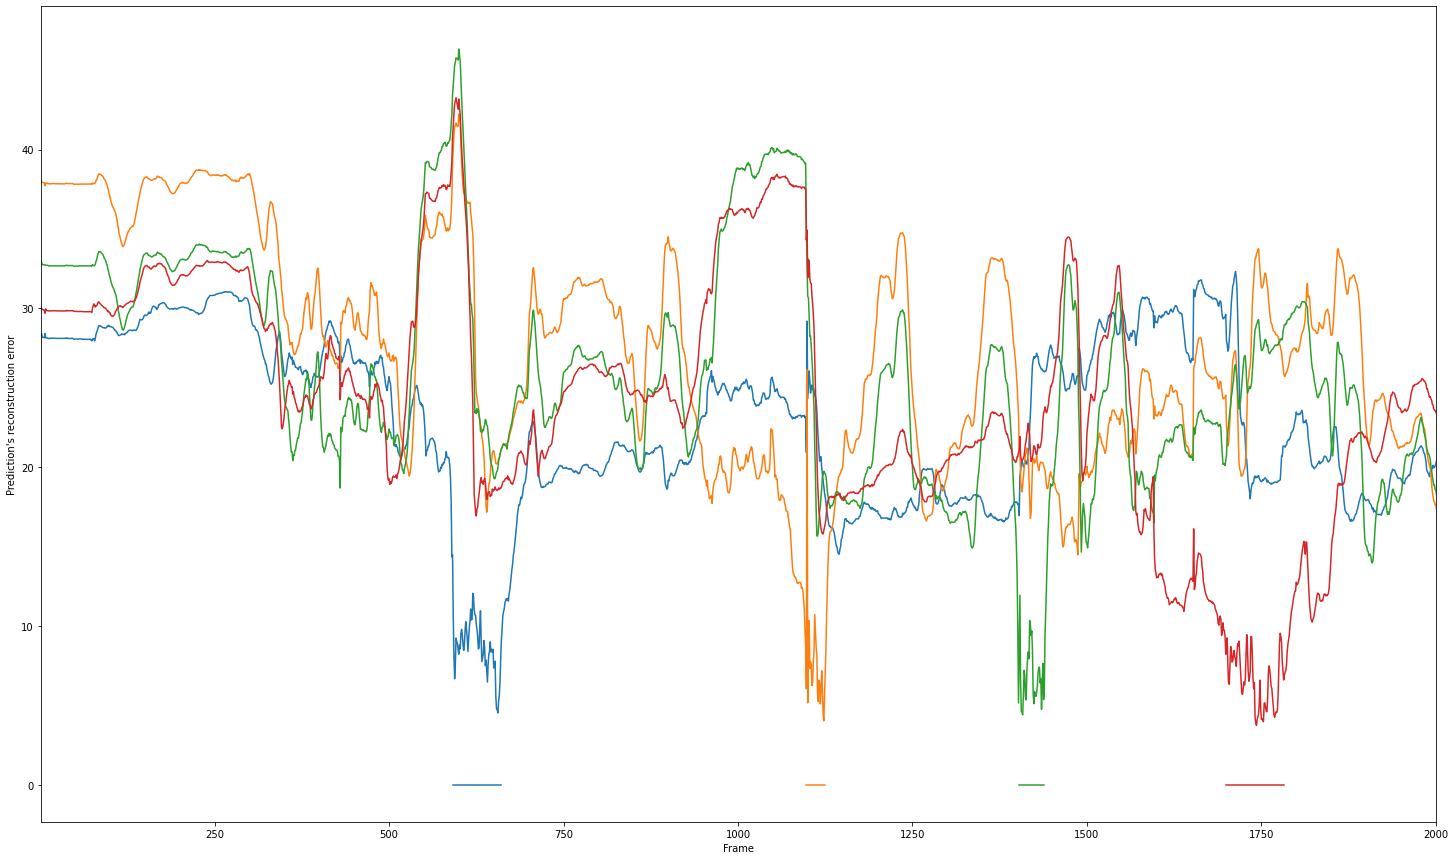

In [42]:
colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 6, 8, 9]]
plt.figure(figsize=(25, 15))
plt.xlabel('Frame')
plt.ylabel("Prediction's reconstruction error")
plt.xlim(1, 2000)

for i, frag in enumerate(all_fragment_info[all_fragment_info[:,-1]==g]):
    plt.plot(np.arange(frag[0], frag[1]+1), int(frag[2])*[0], colors[i])

for i, (compression_model, model_ds) in enumerate(models_g[:4]):
    all_frames = full_video.get_all_frames().reshape(full_video.duration_frames, -1)

    all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A)
    all_frames_pred = np.clip(all_frames_pred, 0, 255)
    errors = np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1))
    plt.plot(np.arange(1, full_video.duration_frames), errors, colors[i])

### Fit models

In [8]:
ncomp = 10

#### Baseline

##### Training

In [29]:
s = 'B'
models_B = {}
for g in gi2descr.keys():
    if g not in videos_train[s]:
        continue
    models_B[g] = []
    videos_for_gesture = videos_train[s][g]
    for video in videos_for_gesture:
        video.torch = False
        all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

        compression_model = custom_pca(ncomp)
        compression_model.fit(all_frames)
        frames_enc, shape = compression_model.encode(all_frames)
        A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

        models_B[g].append((compression_model, A))

##### Testing

In [ ]:
s = 'B'
# With pre-segmented videos
results = {}
for k in range(1,6):
    results[k] = []
    if k > np.min([len(videos_train[s][g]) for g in videos_train[s].keys()]):
        continue
        print('Minimum of sample per gesture bigger than k:', np.min([len(videos_train[s][g]) for g in videos_train[s].keys()]), k)

    for video_i, (video, gt) in enumerate(videos_test[s]):
        video.torch = False
        try:
            all_frames = video.get_all_frames().reshape(video.duration_frames, -1)
        except:
            print(video.duration_frames)

        compression_model = custom_pca(ncomp)
        compression_model.fit(all_frames)
        frames_enc, shape = compression_model.encode(all_frames)
        A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]
        model = (compression_model, A)

        nvideo_per_gesture_max = np.max([len(models_B[g]) for g in models_B.keys()])
        dists = np.full((len(videos_train[s]), nvideo_per_gesture_max), np.inf)
        i2g = {}
        for i, g in enumerate(videos_train[s].keys()):
            i2g.update({i: g})
            for j, model_g in enumerate(models_B[g]):
                dists[i, j] = martin_dist(subspace_angles(model, model_g))

        ranking = []
        for i in range(k):
            best_ind = np.unravel_index(np.argmin(dists, axis=None), dists.shape)
            dists[best_ind] = np.inf
            ranking.append(i2g[best_ind[0]])

        results[k].append((video_i, gt, ranking))

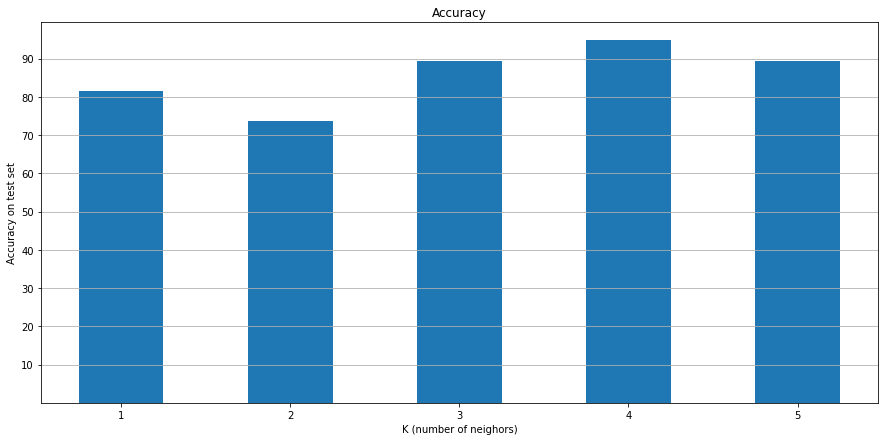

In [150]:
accs = []
for k in results.keys():
    gts = [gt for _, gt, _ in results[k]]
    preds = []
    for _, _, r in results[k]:
        values, counts = np.unique(r, return_counts=True)
        preds.append(values[counts==counts.max()][0])
    preds = np.array(preds)
    accs.append(round(100*np.mean(preds==gts), 2))
plt.figure(figsize=(15,7))
plt.xlabel('K (number of neighors)')
plt.ylabel('Accuracy on test set')
plt.grid(axis='y')
plt.yticks(np.arange(10, 100, 10))
plt.title('Accuracy')
plt.bar(list(results.keys()), accs, width=0.5)
plt.savefig('data_generated/week10_test_accuracy_baseline_B.png')

#### PCA autoencoder

In [9]:
class FramePredictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.predictor = nn.Linear(model.ncomp, model.ncomp)

    def forward(self, x):
        shape = x.shape
        x = self.predictor(x.view(x.shape[0], -1))

        return x.view(shape)

##### Training

In [10]:
s = 'B'
models_pcaae_B = {}
for g in gi2descr.keys():
    if g not in videos_train[s]:
        continue
    models_pcaae_B[g] = []
    videos_for_gesture = videos_train[s][g]
    for video in videos_for_gesture:
        name = !basename $(echo $video.filename)
        #print(f'Fitting {name[0]}: frames {video.start_frame} to {video.start_frame+video.duration_frames}')

        # Train PCA
        video.torch = False
        all_frames = video.get_all_frames().reshape(video.duration_frames, -1)
        pca_model = custom_pca(ncomp)
        pca_model.fit(all_frames)
        frames_enc, shape = pca_model.encode(all_frames)
        A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

        video.torch = True

        # Initialize PCA autoencoder and frame predictor
        compression_model = PCAAutoEncoder((1, video.height, video.width), ncomp)
        state_dict = compression_model.state_dict()
        state_dict['to_lower_rep.weight'] = torch.from_numpy(pca_model.C.T)
        state_dict['to_lower_rep.bias'] = torch.zeros_like(state_dict['to_lower_rep.bias'])
        state_dict['from_lower_rep.weight'] = torch.from_numpy(pca_model.C)
        state_dict['from_lower_rep.bias'] = torch.zeros_like(state_dict['from_lower_rep.bias'])
        compression_model.load_state_dict(state_dict)
        compression_model.to(device)

        model_ds = FramePredictor(compression_model)
        state_dict = model_ds.state_dict()
        state_dict['predictor.weight'] = torch.from_numpy(A.T)
        state_dict['predictor.bias'] = torch.zeros_like(state_dict['predictor.bias'])
        model_ds.load_state_dict(state_dict)
        model_ds.to(device)
        mean,std = pca_model.mean, pca_model.std

        # Compute original loss
        all_frames_pred = []
        for frames in video:
            frames = standardize_frames(frames, mean=mean, std=std).to(device)
            enc = compression_model.encode(frames)
            all_frames_pred.append(compression_model.decode(model_ds(enc)))
        all_frames_pred = torch.cat(all_frames_pred, 0)*std+mean
        all_frames_pred = all_frames_pred[:-1]
        original_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

        # Fine tune
        np.random.seed(seed)
        torch.manual_seed(seed)
        iteration_per_epoch = np.ceil(video.duration_frames/video.batch_size)
        optimizer = Adam(list(compression_model.parameters())+list(model_ds.parameters()), lr=2e-7)
        losses = []
        losses.append(original_loss)
        for epoch in range(15):
            epoch_loss = 0
            for frames in video:
                frames = frames.to(device)
                frames_std = standardize_frames(frames, mean=mean, std=std)
                frames_next_gt = frames[1:]
                frames_enc = compression_model.encode(frames_std[:-1])
                frames_next_std = compression_model.decode(model_ds(frames_enc))
                frames_next = frames_next_std*std + mean

                loss = crit(frames_next, frames_next_gt)
                epoch_loss += loss.item()
                #print(loss)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses.append(epoch_loss/iteration_per_epoch)

        # Compute resulting loss
        all_frames_pred = []
        for frames in video:
            frames = standardize_frames(frames, mean=mean, std=std).to(device)
            enc = compression_model.encode(frames)
            all_frames_pred.append(compression_model.decode(model_ds(enc)))
        all_frames_pred = torch.cat(all_frames_pred, 0)*std+mean
        all_frames_pred = all_frames_pred[:-1]
        resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

        models_pcaae_B[g].append(((compression_model, model_ds), original_loss, resulting_loss, losses))

In [28]:
v = videos_train[s][1][0]
f = next(iter(v))
f, preds = f[1:], all_frames_pred[:63].cpu()
crit(f, preds)

tensor(41.9943, grad_fn=<SqrtBackward>)

In [33]:
for a in [m[1:] for k in models_pcaae_B.keys() for m in models_pcaae_B[k]]:
    print(a)

(13.973092, 13.973181, [13.973092, 3.2750030358632407, 3.274486780166626, 3.2740566730499268, 3.273669640223185, 3.2733236153920493, 3.27301295598348, 3.2727318604787192, 3.2724738121032715, 3.2722326119740806, 3.2720042069753013, 3.271784861882528, 3.271571636199951, 3.271362622578939, 3.2711567083994546, 3.270953098932902])


##### Testing

In [11]:
"""
    Will be the same as PCA as the fine tunîng is of practically no use
"""

s = 'B'
# With pre-segmented videos
max_k = min(7, np.min([len(videos_train[s][g]) for g in videos_train[s].keys()]))
results = []

nvid_test = len(videos_test[s])
for video_i, (video, gt) in enumerate(videos_test[s]):
    video.torch = False
    try:
        all_frames = video.get_all_frames().reshape(video.duration_frames, -1)
    except:
        print('Should not', video.duration_frames)
        continue
    name = !basename $(echo $video.filename)
    print(f'Fitting video fragment {video_i}/{nvid_test} ({name[0]}, frames {video.start_frame} to {video.start_frame+video.duration_frames})')

    # Train PCA
    video.torch = False
    all_frames = video.get_all_frames().reshape(video.duration_frames, -1)
    pca_model = custom_pca(ncomp)
    pca_model.fit(all_frames)
    frames_enc, shape = pca_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    video.torch = True

    # Initialize PCA autoencoder and frame predictor
    compression_model = PCAAutoEncoder((1, video.height, video.width), ncomp)
    state_dict = compression_model.state_dict()
    state_dict['to_lower_rep.weight'] = torch.from_numpy(pca_model.C.T)
    state_dict['to_lower_rep.bias'] = torch.zeros_like(state_dict['to_lower_rep.bias'])
    state_dict['from_lower_rep.weight'] = torch.from_numpy(pca_model.C)
    state_dict['from_lower_rep.bias'] = torch.zeros_like(state_dict['from_lower_rep.bias'])
    compression_model.load_state_dict(state_dict)
    compression_model.to(device)

    model_ds = FramePredictor(compression_model)
    state_dict = model_ds.state_dict()
    state_dict['predictor.weight'] = torch.from_numpy(A.T)
    state_dict['predictor.bias'] = torch.zeros_like(state_dict['predictor.bias'])
    model_ds.load_state_dict(state_dict)
    model_ds.to(device)
    mean,std = pca_model.mean, pca_model.std

    # Compute original loss
    all_frames_pred = []
    for frames in video:
        frames = standardize_frames(frames, mean=mean, std=std).to(device)
        enc = compression_model.encode(frames)
        all_frames_pred.append(compression_model.decode(model_ds(enc)))
    all_frames_pred = torch.cat(all_frames_pred, 0)*std+mean
    all_frames_pred = all_frames_pred[:-1]
    original_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

    # Fine tune
    np.random.seed(seed)
    torch.manual_seed(seed)
    iteration_per_epoch = np.ceil(video.duration_frames/video.batch_size)
    optimizer = Adam(list(compression_model.parameters())+list(model_ds.parameters()), lr=2e-7)
    losses = []
    for epoch in range(15):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            frames_std = standardize_frames(frames, mean=mean, std=std)
            frames_next_gt = frames[1:]
            frames_enc = compression_model.encode(frames_std[:-1])
            frames_next_std = compression_model.decode(model_ds(frames_enc))
            frames_next = frames_next_std*std + mean

            loss = crit(frames_next, frames_next_gt)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(epoch_loss/iteration_per_epoch)
    model = (compression_model, model_ds)

    # Compute resulting loss
    all_frames_pred = []
    for frames in video:
        frames = standardize_frames(frames, mean=mean, std=std).to(device)
        enc = compression_model.encode(frames)
        all_frames_pred.append(compression_model.decode(model_ds(enc)))
    all_frames_pred = torch.cat(all_frames_pred, 0)*std+mean
    all_frames_pred = all_frames_pred[:-1]
    resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])
    print(f'Loss: from {original_loss:.4f} to {resulting_loss:.4f}')

    # Compute distance and classify
    nvideo_per_gesture_max = np.max([len(models_pcaae_B[g]) for g in models_pcaae_B.keys()])
    dists = np.full((len(videos_train[s]), nvideo_per_gesture_max), np.inf)
    i2g = {}
    for i, g in enumerate(videos_train[s].keys()):
        i2g.update({i: g})
        for j, model_g in enumerate(models_pcaae_B[g]):
            model_g = model_g[0]
            try:
                dists[i, j] = martin_dist(subspace_angles(model, model_g, C_key='from_lower_rep.weight'))
            except KeyError:
                print(i,g,j)
                print(model, model_g)

    ranking = []
    for i in range(max_k):
        best_ind = np.unravel_index(np.argmin(dists, axis=None), dists.shape)
        dists[best_ind] = np.inf
        ranking.append(i2g[best_ind[0]])

    results.append((video_i, gt, ranking))

Fitting video fragment 0/38 (Suturing_B005_capture1.avi, frames 1 to 12)
Loss: from 0.1396 to 0.1396
Fitting video fragment 1/38 (Suturing_B005_capture1.avi, frames 12 to 102)
Loss: from 4.8175 to 4.8173
Fitting video fragment 2/38 (Suturing_B005_capture1.avi, frames 102 to 447)
Loss: from 7.9418 to 7.9416
Fitting video fragment 3/38 (Suturing_B005_capture1.avi, frames 447 to 517)
Loss: from 5.8957 to 5.8971
Fitting video fragment 4/38 (Suturing_B005_capture1.avi, frames 517 to 968)
Loss: from 7.3271 to 7.3273
Fitting video fragment 5/38 (Suturing_B005_capture1.avi, frames 968 to 1116)
Loss: from 6.2894 to 6.2894
Fitting video fragment 6/38 (Suturing_B005_capture1.avi, frames 1116 to 1187)
Loss: from 5.5772 to 5.5775
Fitting video fragment 7/38 (Suturing_B005_capture1.avi, frames 1187 to 1262)
Loss: from 7.2225 to 7.2220
Fitting video fragment 8/38 (Suturing_B005_capture1.avi, frames 1262 to 1490)
Loss: from 7.6413 to 7.6409
Fitting video fragment 9/38 (Suturing_B005_capture1.avi, fram

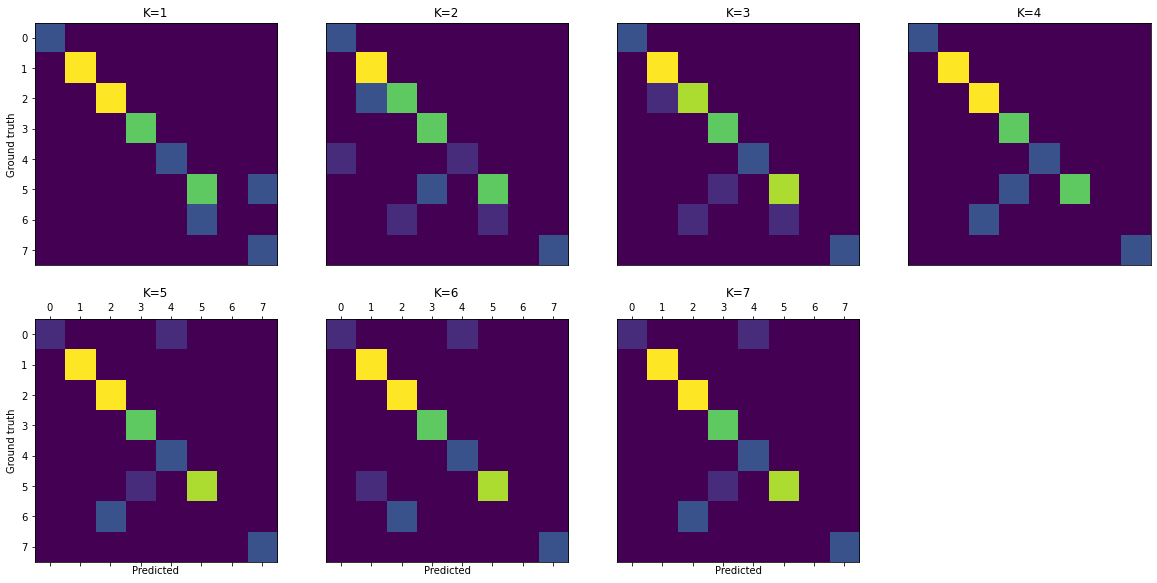

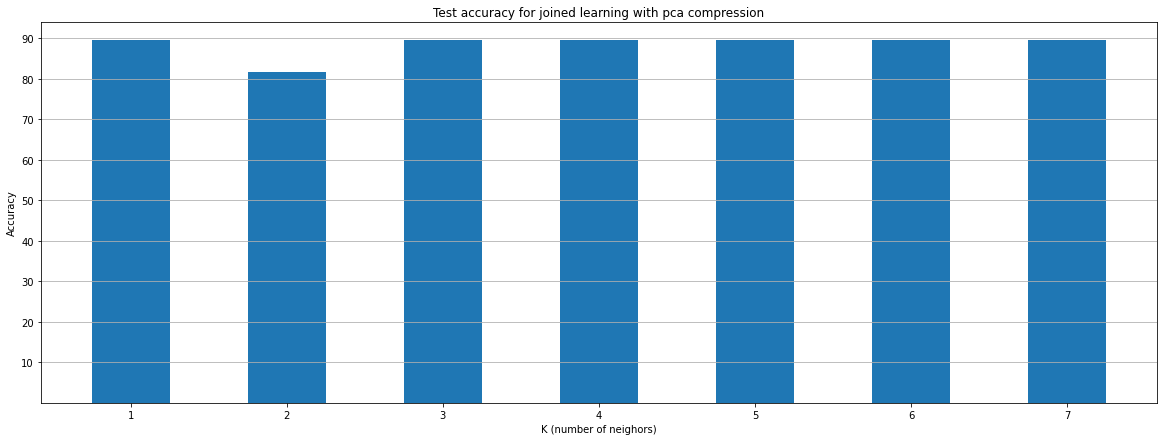

In [44]:
accs = []
all_gestures = np.unique([[gt]+r for _, gt, r in results])
g2i_confusion = {g: i for i, g in enumerate(all_gestures)}
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.figsize = (20, 10)
for i, k in enumerate(range(1, max_k+1)):
    confusion_matrix = np.zeros((len(all_gestures), len(all_gestures)))
    gts = [gt for _, gt, _ in results]
    preds = []
    for _, gt, r in results:
        r = r[:k]
        values, counts = np.unique(r, return_counts=True)
        preds.append(values[counts==counts.max()][0])
        confusion_matrix[g2i_confusion[gt], g2i_confusion[preds[-1]]] += 1
    preds = np.array(preds)
    current_acc = round(100*np.mean(preds==gts), 2)
    accs.append(current_acc)
    axs[i//4,i%4].matshow(confusion_matrix)
    axs[i//4,i%4].set_title(f'K={k}')

for ax in axs.flat:
    ax.set(xlabel='Predicted', ylabel='Ground truth')
[ax.xaxis.set_visible(False) for ax in axs[0].ravel()]
[ax.yaxis.set_visible(False) for ax in axs[:,1:].ravel()]
axs[0,1].yaxis.set_visible(False)
axs[-1,-1].axis('off')
plt.savefig('data_generated/week11_confusion_pcaae.png')
plt.show()

plt.figure(figsize=(20,7))
plt.xlabel('K (number of neighors)')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.yticks(np.arange(10, 100, 10))
plt.title('Test accuracy for joined learning with pca compression')
plt.bar(range(1, max_k+1), accs, width=0.5)
plt.savefig('data_generated/week10_test_accuracy_pcaae_B.png')

#### One hidden layer autoencoder

##### Training

In [ ]:
s = 'B'
models_oneh_B = {}
for g in gi2descr.keys():
    if g not in videos_train[s]:
        continue
    print('Gesture', g, '(', gi2descr[g], ')')
    models_oneh_B[g] = []
    videos_for_gesture = videos_train[s][g]
    nvid_gesture = len(videos_for_gesture)
    for nvid, video in enumerate(videos_for_gesture, 1):
        name = !basename $(echo $video.filename)
        print(f'Fitting video fragment {nvid}/{nvid_gesture} ({name[0]}, frames {video.start_frame} to {video.start_frame+video.duration_frames}) (allocated: {torch.cuda.memory_allocated()/1e6:.2f}mb)')

        video.torch = True
        np.random.seed(seed)
        torch.manual_seed(seed)
        iteration_per_epoch = np.ceil(video.duration_frames/video.batch_size)

        compression_model = OneHAutoEncoder((1, meta['h'], meta['w']), 10)
        compression_model.load_state_dict(models['10-OneHAE']['model'])
        compression_model.to(device)
        model_ds = FramePredictor(compression_model).to(device)

        losses_oneh = []
        epoch_ds, epoch_tot = 10, 50

        # Train transition matrix
        optimizer_ds = Adam(model_ds.parameters(), lr=0.005)
        for epoch in range(epoch_ds):
            epoch_loss = 0
            for frames in video:
                frames = frames.to(device)
                frames_next_gt = frames[1:]
                frames_enc = compression_model.encode(frames[:-1])
                frames_next = compression_model.decode(model_ds(frames_enc))

                loss = crit(frames_next.squeeze(), frames_next_gt.squeeze())
                epoch_loss += loss.item()

                optimizer_ds.zero_grad()
                loss.backward()
                optimizer_ds.step()
            losses_oneh.append(epoch_loss/iteration_per_epoch)

        optimizer = Adam(compression_model.parameters(), lr=models['10-OneHAE']['lr'])
        optimizer.load_state_dict(models['10-OneHAE']['optimizer'])
        optimizer_ds = Adam(model_ds.parameters(), lr=0.0005)
        current_opt, current_opt_descr = optimizer_ds, 'dynamical system'
        other_opt, other_opt_descr = optimizer, 'compression model'
        # Training transition matrix and compression model
        for epoch in range(epoch_ds, epoch_tot):
            epoch_loss = 0
            if epoch % 5 == 0:
                current_opt, other_opt = other_opt, current_opt
                current_opt_descr, other_opt_descr = other_opt_descr, current_opt_descr
            for frames in video:
                frames = frames.to(device)
                frames_next_gt = frames[1:]
                frames_enc = compression_model.encode(frames[:-1])
                frames_next = compression_model.decode(model_ds(frames_enc))

                loss = crit(frames_next, frames_next_gt)
                epoch_loss += loss.item()

                current_opt.zero_grad()
                loss.backward()
                current_opt.step()
            losses_oneh.append(epoch_loss/iteration_per_epoch)

        # Compute resulting loss
        all_frames_pred = []
        for frames in video:
            frames = frames.to(device)
            enc = compression_model.encode(frames)
            all_frames_pred.append(compression_model.decode(model_ds(enc)))
        all_frames_pred = torch.cat(all_frames_pred, 0)
        all_frames_pred = all_frames_pred[:-1]
        resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

        models_oneh_B[g].append(((None, model_ds.state_dict()['predictor.weight'].T.detach()), resulting_loss, losses_oneh))


Gesture 1 ( Reaching for needle with right hand )
Fitting video fragment 1/8 (Suturing_B001_capture1.avi, frames 80 to 220) (allocated: 1138.57mb)
Fitting video fragment 2/8 (Suturing_B001_capture2.avi, frames 80 to 220) (allocated: 937.92mb)
Fitting video fragment 3/8 (Suturing_B002_capture1.avi, frames 5 to 79) (allocated: 937.17mb)
Fitting video fragment 4/8 (Suturing_B002_capture2.avi, frames 5 to 79) (allocated: 901.48mb)
Fitting video fragment 5/8 (Suturing_B003_capture1.avi, frames 8 to 104) (allocated: 901.48mb)
Fitting video fragment 6/8 (Suturing_B003_capture2.avi, frames 8 to 104) (allocated: 924.71mb)
Fitting video fragment 7/8 (Suturing_B004_capture1.avi, frames 1 to 47) (allocated: 924.71mb)
Fitting video fragment 8/8 (Suturing_B004_capture2.avi, frames 1 to 47) (allocated: 905.41mb)
Gesture 2 ( Positioning needle )
Fitting video fragment 1/40 (Suturing_B001_capture1.avi, frames 591 to 661) (allocated: 905.41mb)
Fitting video fragment 2/40 (Suturing_B001_capture1.avi, fra

In [ ]:
mean_dists = np.zeros((models_oneh_B.keys(), models_oneh_B.keys()))
for i, g1 in enumerate(models_oneh_B.keys()):
    for j, g2 in enumerate(models_oneh_B.keys()):
        temp = []
        for mg1 in models_oneh_B[g1][:5]:
            for mg2 in models_oneh_B[g2][:5]:
                temp.append(martin_dist(subspace_angles(mg1, mg2, C_key='from_lower_rep.weight')))
        mean_dists[i,j] = np.mean(temp)
plt.matshow(mean_dists)
plt.colorbar()
plt.show()

##### Testing

In [52]:
s = 'B'
# With pre-segmented videos
max_k = min(7, np.min([len(videos_train[s][g]) for g in videos_train[s].keys()]))
results_oneh = []

nvid_test = len(videos_test[s])
for video_i, (video, gt) in enumerate(videos_test[s]):
    video.torch = False
    try:
        all_frames = video.get_all_frames().reshape(video.duration_frames, -1)
    except:
        print('Should not', video.duration_frames)
        continue
    name = !basename $(echo $video.filename)
    print(f'Fitting video fragment {video_i}/{nvid_test} ({name[0]}, frames {video.start_frame} to {video.start_frame+video.duration_frames})')

    video.torch = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    iteration_per_epoch = np.ceil(video.duration_frames/video.batch_size)

    compression_model = OneHAutoEncoder((1, meta['h'], meta['w']), 10)
    compression_model.load_state_dict(models['10-OneHAE']['model'])
    compression_model.to(device)
    model_ds = FramePredictor(compression_model).to(device)

    losses_oneh = []
    epoch_ds, epoch_tot = 10, 50

    # Train transition matrix
    optimizer_ds = Adam(model_ds.parameters(), lr=0.005)
    for epoch in range(epoch_ds):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            frames_next_gt = frames[1:]
            frames_enc = compression_model.encode(frames[:-1])
            frames_next = compression_model.decode(model_ds(frames_enc))

            loss = crit(frames_next.squeeze(), frames_next_gt.squeeze())
            epoch_loss += loss.item()

            optimizer_ds.zero_grad()
            loss.backward()
            optimizer_ds.step()
        losses_oneh.append(epoch_loss/iteration_per_epoch)

    optimizer = Adam(compression_model.parameters(), lr=models['10-OneHAE']['lr'])
    optimizer.load_state_dict(models['10-OneHAE']['optimizer'])
    optimizer_ds = Adam(model_ds.parameters(), lr=0.0005)
    current_opt, current_opt_descr = optimizer_ds, 'dynamical system'
    other_opt, other_opt_descr = optimizer, 'compression model'
    # Training transition matrix and compression model
    for epoch in range(epoch_ds, epoch_tot):
        epoch_loss = 0
        if epoch % 5 == 0:
            current_opt, other_opt = other_opt, current_opt
            current_opt_descr, other_opt_descr = other_opt_descr, current_opt_descr
        for frames in video:
            frames = frames.to(device)
            frames_next_gt = frames[1:]
            frames_enc = compression_model.encode(frames[:-1])
            frames_next = compression_model.decode(model_ds(frames_enc))

            loss = crit(frames_next, frames_next_gt)
            epoch_loss += loss.item()

            current_opt.zero_grad()
            loss.backward()
            current_opt.step()
        losses_oneh.append(epoch_loss/iteration_per_epoch)
    model = (None, model_ds)

    # Compute resulting loss
    all_frames_pred = []
    for frames in video:
        frames = frames.to(device)
        enc = compression_model.encode(frames)
        all_frames_pred.append(compression_model.decode(model_ds(enc)))
    all_frames_pred = torch.cat(all_frames_pred, 0)
    all_frames_pred = all_frames_pred[:-1]
    resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

    # Compute resulting loss
    all_frames_pred = []
    for frames in video:
        frames = frames.to(device)
        enc = compression_model.encode(frames)
        all_frames_pred.append(compression_model.decode(model_ds(enc)))
    all_frames_pred = torch.cat(all_frames_pred, 0)
    all_frames_pred = all_frames_pred[:-1]
    resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])
    print(f'Final loss: {resulting_loss:.4f}')

    # Compute distance and classify
    nvideo_per_gesture_max = np.max([len(models_oneh_B[g]) for g in models_oneh_B.keys()])
    dists = np.full((len(videos_train[s]), nvideo_per_gesture_max), np.inf)
    i2g = {}
    for i, g in enumerate(videos_train[s].keys()):
        i2g.update({i: g})
        for j, model_g in enumerate(models_oneh_B[g]):
            model_g = model_g[0]
            dists[i, j] = martin_dist(subspace_angles(model, model_g, C_key='from_lower_rep.weight', p=256**2))

    ranking = []
    for i in range(max_k):
        best_ind = np.unravel_index(np.argmin(dists, axis=None), dists.shape)
        dists[best_ind] = np.inf
        ranking.append(i2g[best_ind[0]])
    print(ranking, 'vs', gt)

    results_oneh.append((video_i, gt, ranking))


Fitting video fragment 0/38 (Suturing_B005_capture1.avi, frames 1 to 12)
Final loss: 65.3490
[2, 2, 3, 2, 3, 3, 3] vs 1
Fitting video fragment 1/38 (Suturing_B005_capture1.avi, frames 12 to 102)
Final loss: 25.2146
[2, 2, 2, 3, 3, 3, 3] vs 5
Fitting video fragment 2/38 (Suturing_B005_capture1.avi, frames 102 to 447)
Final loss: 22.1432
[2, 2, 2, 3, 3, 3, 3] vs 8
Fitting video fragment 3/38 (Suturing_B005_capture1.avi, frames 447 to 517)
Final loss: 27.3642
[2, 2, 2, 3, 3, 3, 3] vs 2
Fitting video fragment 4/38 (Suturing_B005_capture1.avi, frames 517 to 968)
Final loss: 22.0027
[2, 2, 2, 3, 3, 8, 3] vs 3
Fitting video fragment 5/38 (Suturing_B005_capture1.avi, frames 968 to 1116)
Final loss: 19.9128
[2, 2, 3, 3, 3, 6, 6] vs 6
Fitting video fragment 6/38 (Suturing_B005_capture1.avi, frames 1116 to 1187)
Final loss: 27.4052
[2, 2, 3, 2, 3, 3, 3] vs 4
Fitting video fragment 7/38 (Suturing_B005_capture1.avi, frames 1187 to 1262)
Final loss: 27.7718
[2, 2, 2, 3, 3, 3, 3] vs 2
Fitting video f

In [57]:
results_oneh = results_tempconv

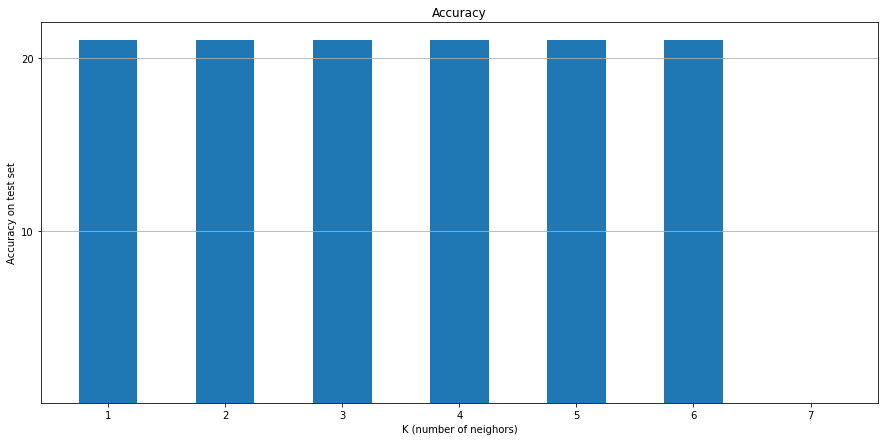

In [60]:
accs = []
for k in range(1, max_k+1):
    gts = [gt for _, gt, _ in results_oneh]
    preds = []
    for _, _, r in results_oneh:
        r = r[:k]
        values, counts = np.unique(r, return_counts=True)
        preds.append(values[counts==counts.max()][0])
    preds = np.array(preds)
    accs.append(round(100*np.mean(preds==gts), 2))
plt.figure(figsize=(15,7))
plt.xlabel('K (number of neighors)')
plt.ylabel('Accuracy on test set')
plt.grid(axis='y')
plt.yticks(np.arange(10, 100, 10))
plt.title('Accuracy')
plt.bar(range(1, max_k+1), accs, width=0.5)
plt.savefig('data_generated/week10_test_accuracy_oneh_B.png')

#### Temporal convolutional autoencoder

##### Training

In [ ]:
temporal_batch_size = 16

s = 'B'
models_tempconv_B = {}
for g in gi2descr.keys():
    if g not in videos_train[s]:
        continue
    print('Gesture', g, '(', gi2descr[g], ')')
    models_tempconv_B[g] = []
    videos_for_gesture = videos_train[s][g]
    nvid_gesture = len(videos_for_gesture)
    for nvid, video in enumerate(videos_for_gesture, 1):
        name = !basename $(echo $video.filename)
        print(f'Fitting video fragment {nvid}/{nvid_gesture} ({name[0]}, frames {video.start_frame} to {video.start_frame+video.duration_frames})')

        video.torch = True
        video.sample_shape = (1, temporal_batch_size, video.height, video.width)
        video.iterator_stride = 1
        video.batch_size = 16
        np.random.seed(seed)
        torch.manual_seed(seed)
        iteration_per_epoch = video.duration_frames - video.batch_size

        compression_model = TemporalConvAE(1, 2, 32, 10)
        compression_model.load_state_dict(models['10-TempConvAE']['model'])
        compression_model.to(device)
        model_ds = FramePredictor(compression_model).to(device)

        losses_tempconv = []
        epoch_ds, epoch_tot = 10, 50

        # Train transition matrix
        optimizer_ds = Adam(model_ds.parameters(), lr=0.005)
        for epoch in range(epoch_ds):
            epoch_loss = 0
            cnt = 0
            x_prev = None
            loss = 0
            for i, frames in enumerate(video):
                frames = frames.to(device)
                x = compression_model.encode(frames)
                if x_prev is None:
                    x_prev = x.detach()
                    continue
                x_pred = model_ds(x_prev)
                loss = loss + crit(compression_model.decode(x_pred), frames)
                cnt += 1
                x_pred = x.detach()

                if (i+1) % video.batch_size == 0:
                    optimizer_ds.zero_grad()

                    loss.backward(retain_graph=True)
                    epoch_loss += loss.item()
                    loss = 0
                    optimizer_ds.step()
            losses_tempconv.append(epoch_loss/iteration_per_epoch)

        optimizer = Adam(compression_model.parameters(), lr=0.0001)
        # Training transition matrix and compression model
        for epoch in range(epoch_ds, epoch_tot):
            epoch_loss = 0
            cnt = 0
            x_prev = None
            loss = 0
            for i, frames in enumerate(video):
                frames = frames.to(device)
                x = compression_model.encode(frames)
                if x_prev is None:
                    x_prev = x.detach()
                    continue
                x_pred = model_ds(x_prev)
                loss = loss + crit(compression_model.decode(x_pred), frames)
                cnt += 1
                x_pred = x.detach()

                if (i+1) % video.batch_size == 0:
                    optimizer.zero_grad()

                    loss.backward(retain_graph=True)
                    epoch_loss += loss.item()
                    loss = 0
                    optimizer.step()

            losses_tempconv.append(epoch_loss/iteration_per_epoch)

        # Compute resulting loss
        all_frames_pred = []
        for frames in video:
            frames = frames.to(device)
            enc = compression_model.encode(frames)
            all_frames_pred.append(compression_model.decode(model_ds(enc)))
        all_frames_pred = torch.cat(all_frames_pred, 0)*std+mean
        all_frames_pred = all_frames_pred[:-1]
        print(all_frames_pred.shape, video.duration_frames)
        resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

        models_tempconv_B[g].append(((), original_loss, resulting_loss, losses))

## Compression models

In [2]:
def compression_train_helper(model_key, base_model, model_args, video, lrs, models, num_epoch_tune=10, num_epoch=40):
    iteration_per_epoch = int(video.duration_frames/video.batch_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device', device)
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))

    losses_tune = []
    for lr in lrs:
        if len(lrs) == 1:
            losses_tune.append(0)
            break
        torch.manual_seed(seed)
        np.random.seed(seed)
        model = base_model(*model_args).to(device)
        optimizer = Adam(model.parameters(), lr=lr)
        for epoch in range(num_epoch_tune):
            epoch_loss = 0
            for frames in video:
                frames = frames.to(device)
                reconstructed = model(frames)
                loss = crit(frames, reconstructed)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
        losses_tune.append(epoch_loss / iteration_per_epoch)
        if len(losses_tune) >= 2 and losses_tune[-1] > losses_tune[-2]:
            break
    lr = lrs[np.argmin(losses_tune)]
    print('Chosen learning rate:', lr)
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = base_model(*model_args).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    t1 = time()
    losses = []
    for epoch in range(num_epoch):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            reconstructed = model(frames)
            loss = crit(frames, reconstructed)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / iteration_per_epoch)
        if (epoch+1) % 3 == 0:
            print(f'\t Error at epoch {epoch+1}:', losses[-1])

    model_dict = {
        'model': model.state_dict(),
        'epoch': num_epoch,
        'optimizer': optimizer.state_dict(),
        'lr': lr,
        'losses_tune': losses_tune,
        'lrs': lrs,
        'losses': losses,
        'epoch_time': (time()-t1)/num_epoch
    }
    models[model_key] = model_dict
    return model

def evaluate_model(model, model_key, models, meta):
    reconstructed_train = video_train.reduce_latent(model, trans=False)
    reconstructed_test = video_test.reduce_latent(model, trans=False)
    original_frames_train_ = original_frames_train.numpy().reshape(-1, *video_train.sample_shape)
    original_frames_test_  = original_frames_test.numpy().reshape(-1, *video_test.sample_shape)
    models[key]['train_error'] = reconstruction_error(original_frames_train_, reconstructed_train.numpy())
    models[key]['test_error'] = reconstruction_error(original_frames_test_, reconstructed_test.numpy())
    print('Training error:', models[key]['train_error'])
    print('Testing error:', models[key]['test_error'])
    reconstructed_train_ = reconstructed_train.numpy().reshape(-1, video_train.height, video_train.width)
    write_video(key+'.mp4', reconstructed_train_, meta['w'], meta['h'], meta['fps'], meta['gray'])
    print('Video for '+key+' written')

video_train = VideoLoader(video_path, duration=30, gray=True)
video_test =  VideoLoader(video_path, start=30, duration=10, gray=True)
meta = {'w': video_train.width,
        'h': video_train.height,
        'fps': video_train.fps,
        'bs': video_train.batch_size,
        'gray': video_train.gray}
original_frames_train = video_train.get_all_frames()
original_frames_test = video_test.get_all_frames()
num_epoch, num_epoch_tune = 40, 10

_ = """
############   PCA autoencoder   ############
lrs = [1e-05, 5e-05, 1e-04]
key = '50-PCAAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, meta['h'], meta['w'])
model = compression_train_helper(key, PCAAutoEncoder, ((1, meta['w'], meta['h']), 50), video_train,
                           lrs, models, num_epoch=50)

evaluate_model(model, key, models, meta)

############ One hidden layer AE ############
key = '10-OneHAE'
print('\nModel', key)
lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
video_train.sample_shape = video_test.sample_shape = (1, meta['h'], meta['w'])
model = compression_train_helper(key, OneHAutoEncoder, ((1, meta['h'], meta['w']), 10), video_train,
                          lrs, models)

evaluate_model(model, key, models, meta)

############   Temporal Conv AE   ############
key = 'TempConvAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, 16, meta['h'], meta['w'])
model = compression_train_helper(key, TemporalConvAE, (1, 2, 32), video_train, lrs, models)

evaluate_model(model, key, models, meta)

############  160-Temporal Conv AE  ############
key = '10-TempConvAE'
print('\nModel', key)
video_train.sample_shape = video_test.sample_shape = (1, 16, meta['h'], meta['w'])
model = train_helper(key, TemporalConvAE, (1, 2, 32, 160), video_train, lrs, models)

evaluate_model(model, key, models, meta)
"""

## Classification algorithm

#### Model comparison

A model is a tuple: the compression model and the dynamical system. The compression model is either a model with a `C` attribute being the matrix of projection or a non-linear compression model in which case the `C` matrix associated with it will be $I_{p \times n}$

For now the bias in the dynamical system are ignored

In [160]:
# Model definition

## Baseline, separated learning
video.torch = False
all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

model_pca = custom_pca(10)
model_pca.fit(all_frames)
frames_enc, shape = model_pca.encode(all_frames)
A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]
model1 = (model_pca, A)

## Baseline as autoencoder (Created and trained below)
model2 = (model, model_ds)

subspace_angles(model1, model2, A2_key='predictor.weight', C2_key='from_lower_rep.weight')

array([0.058563  , 0.038213  , 0.03299011, 0.03039991, 0.02452698,
       0.01096707, 0.01312446, 0.01989882, 0.01622211, 0.01752454,
       0.058563  , 0.038213  , 0.03299011, 0.03039991, 0.02452698,
       0.01096707, 0.01312446, 0.01989882, 0.01622211, 0.01752454])

## Dynamical system models

### Baseline

In [137]:
video.torch = False
all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

model_pca = custom_pca(10)
model_pca.fit(all_frames)

In [138]:
frames_enc, shape = model_pca.encode(all_frames)
A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]
print(frames_enc.shape, A.shape)

(960, 10) (10, 10)


In [139]:
Y_pred = model_pca.decode(frames_enc[:-1]@A)
error_pca = reconstruction_error(Y_pred, all_frames[1:])
print('Error on prediction:', error_pca)
print('Error on reconstruction:', reconstruction_error(all_frames, model_pca.decode(frames_enc)))

Error on prediction: 8.326775
Error on reconstruction: 8.126883


### PCA jointly optimized, initialized with the baseline transformation

In [140]:
class FramePredictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.predictor = nn.Linear(model.ncomp, model.ncomp)

    def forward(self, x):
        shape = x.shape
        x = self.predictor(x.view(x.shape[0], -1))

        return x.view(shape)

#### Initialization as PCA

In [141]:
video = VideoLoader(video_path, duration=30, gray=True)
iteration_per_epoch = int(video.duration_frames/video.batch_size)
model = PCAAutoEncoder((1, meta['h'], meta['w']), 10).to(device)

state_dict = model.state_dict()
state_dict['to_lower_rep.weight'] = torch.from_numpy(model_pca.C.T).to(device)
state_dict['to_lower_rep.bias'] = torch.zeros_like(state_dict['to_lower_rep.bias'])
state_dict['from_lower_rep.weight'] = torch.from_numpy(model_pca.C).to(device)
state_dict['from_lower_rep.bias'] = torch.zeros_like(state_dict['from_lower_rep.bias'])
model.load_state_dict(state_dict)
model_ds = FramePredictor(model).to(device)
state_dict = model_ds.state_dict()
state_dict['predictor.weight'] = torch.from_numpy(A.T).to(device)
state_dict['predictor.bias'] = torch.zeros_like(state_dict['predictor.bias'])
model_ds.load_state_dict(state_dict)
mean,std = model_pca.mean, model_pca.std

#### Verification of the error

In [8]:
frames_rec = []
for frames in video:
    frames = standardize_frames(frames, mean=model_pca.mean, std=model_pca.std).to(device)
    frames_rec.append(model(frames))
frames_rec = torch.cat(frames_rec, 0)*model_pca.std+model_pca.mean

print('Error on reconstruction:', crit(frames_rec.squeeze().to('cpu'), video.get_all_frames()).item())

Error on reconstruction: 8.105321884155273


In [9]:
frames_pred = []
for frames in video:
    frames = standardize_frames(frames, mean=model_pca.mean, std=model_pca.std).to(device)
    enc = model.encode(frames)
    frames_pred.append(model.decode(model_ds(enc)))
frames_pred = torch.cat(frames_pred, 0)*model_pca.std+model_pca.mean
frames_pred = frames_pred[:-1]

print('Error on prediction:', crit(frames_pred.squeeze().to('cpu'), video.get_all_frames()[1:]).item())

Error on prediction: 8.305706024169922


#### Fine-tuning of the model

Epoch 1: 8.1148832321167
Epoch 6: 8.06935354868571
Epoch 11: 8.062978903452555
Epoch 16: 8.061997191111248


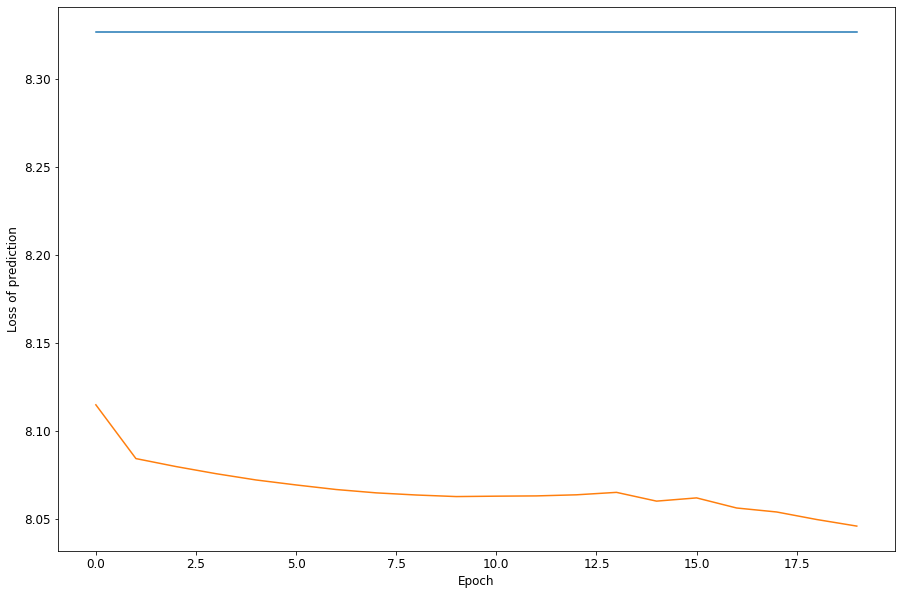

In [142]:
# Joint training
np.random.seed(seed)
torch.manual_seed(seed)
optimizer_both = Adam(list(model.parameters())+list(model_ds.parameters()), lr=0.00001)

losses_pcaae = []
for epoch in range(20):
    epoch_loss = 0
    for frames in video:
        frames = frames.to(device)
        frames_std = standardize_frames(frames, mean=mean, std=std)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames_std[:-1])
        frames_next_std = model.decode(model_ds(frames_enc))
        frames_next = frames_next_std*std + mean

        loss = crit(frames_next, frames_next_gt)
        epoch_loss += loss.item()

        optimizer_both.zero_grad()
        loss.backward()
        optimizer_both.step()
    losses_pcaae.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch)
plot(range(20), [20*[8.326775], losses_pcaae], xlabel='Epoch', ylabel='Loss of prediction')

### Using OneH network for compression

#### One hidden layer autoencoder with initialization as after training of compression model

Training transition matrix
Epoch 1: 128.7869074503581
Epoch 6: 14.27553939819336
Training transition matrix and compression model
Epoch 11: 64.07721532185873 (optimizing compression model)
Epoch 16: 15.054534339904786 (optimizing dynamical system)
Epoch 21: 15.604681015014648 (optimizing compression model)
Epoch 26: 14.407950973510742 (optimizing dynamical system)
Epoch 31: 14.294347890218098 (optimizing compression model)
Epoch 36: 13.958980178833007 (optimizing dynamical system)
Epoch 41: 13.951625951131184 (optimizing compression model)
Epoch 46: 13.742918777465821 (optimizing dynamical system)
Epoch 51: 13.756185658772786 (optimizing compression model)


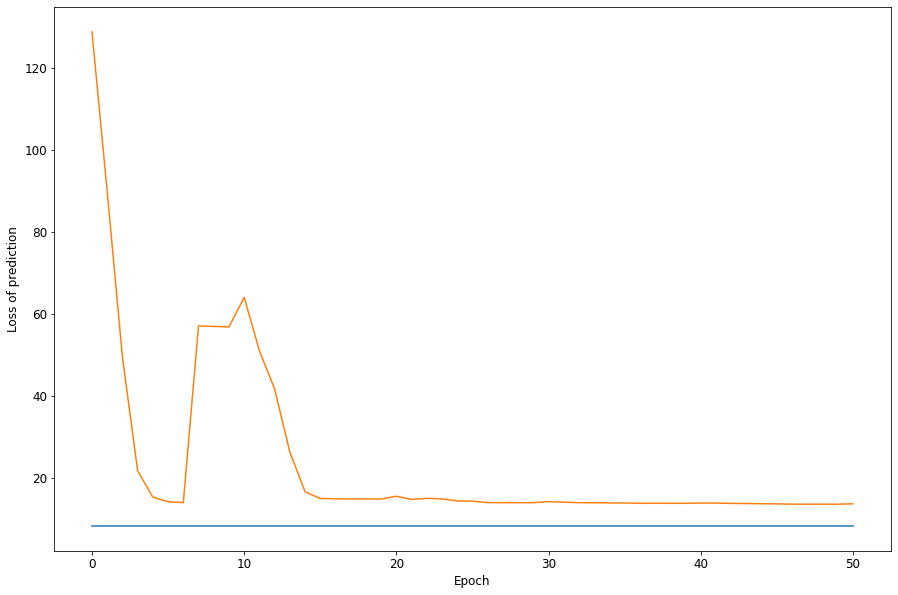

In [68]:
np.random.seed(seed)
torch.manual_seed(seed)
video = VideoLoader(video_path, duration=30, gray=True)
iteration_per_epoch = int(video.duration_frames/video.batch_size)

model = OneHAutoEncoder((1, meta['h'], meta['w']), 10)
model.load_state_dict(models['10-OneHAE']['model'])
model.to(device)
model_ds = FramePredictor(model).to(device)
optimizer_ds = Adam(model_ds.parameters(), lr=0.005)

losses_oneh = []
epoch_ds, epoch_tot = 7, 51
print('Training transition matrix')
for epoch in range(epoch_ds):
    epoch_loss = 0
    for frames in video:
        frames = frames.to(device)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames[:-1])
        frames_next = model.decode(model_ds(frames_enc))

        loss = crit(frames_next.squeeze(), frames_next_gt)
        epoch_loss += loss.item()

        optimizer_ds.zero_grad()
        loss.backward()
        optimizer_ds.step()
    losses_oneh.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch)

optimizer = Adam(model.parameters(), lr=models['10-OneHAE']['lr'])
optimizer.load_state_dict(models['10-OneHAE']['optimizer'])
optimizer_ds = Adam(model_ds.parameters(), lr=0.0005)
current_opt, current_opt_descr = optimizer_ds, 'dynamical system'
other_opt, other_opt_descr = optimizer, 'compression model'
print('Training transition matrix and compression model')
for epoch in range(epoch_ds, epoch_tot):
    epoch_loss = 0
    if epoch % 5 == 0:
        current_opt, other_opt = other_opt, current_opt
        current_opt_descr, other_opt_descr = other_opt_descr, current_opt_descr
    for frames in video:
        frames = frames.to(device)
        frames_std = standardize_frames(frames, mean=mean, std=std)
        frames_next_gt = frames[1:]
        frames_enc = model.encode(frames_std[:-1])
        frames_next_std = model.decode(model_ds(frames_enc))
        frames_next = frames_next_std*std + mean

        loss = crit(frames_next, frames_next_gt)
        epoch_loss += loss.item()

        current_opt.zero_grad()
        loss.backward()
        current_opt.step()
    losses_oneh.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch, f'(optimizing {current_opt_descr})')
plot(range(epoch_tot), [epoch_tot*[8.326775], losses_oneh], xlabel='Epoch', ylabel='Loss of prediction')

### Using spatio-temporal convolutional network for compression

#### Train with initialization as after training of compression model

Training transition matrix
Epoch 1: 46.305629229141495
Epoch 6: 14.932292162361792
Training transition matrix and compression model
Epoch 11: 15.25699321294235 (optimizing compression model)
Epoch 16: 15.133763814376572 (optimizing compression model)
Epoch 21: 15.039607694593526 (optimizing compression model)
Epoch 26: 14.963500459315414 (optimizing compression model)
Epoch 31: 14.899821394580906 (optimizing compression model)
Epoch 36: 14.846452405897237 (optimizing compression model)
Epoch 41: 14.801777435561357 (optimizing compression model)
Epoch 46: 14.762775776749951 (optimizing compression model)


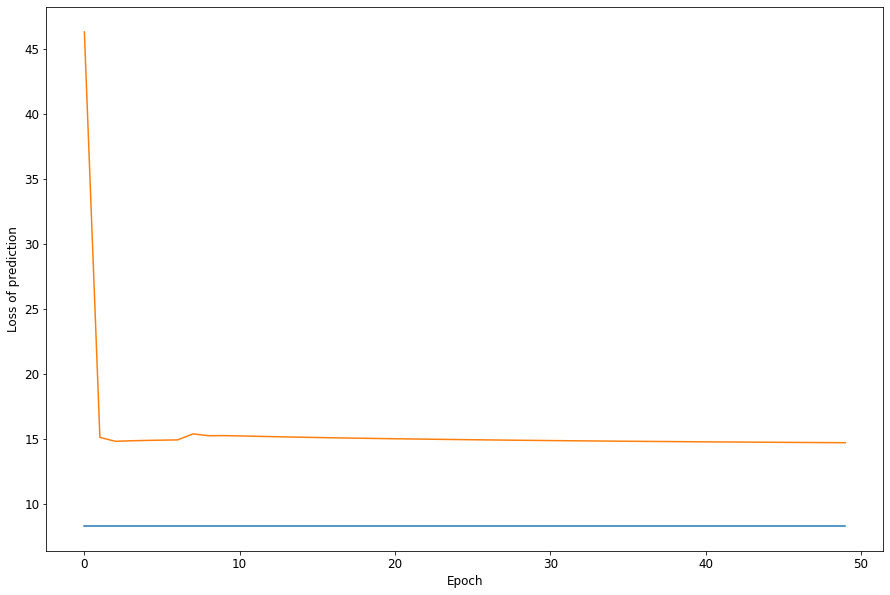

In [69]:
np.random.seed(seed)
torch.manual_seed(seed)
video.torch = True
temporal_batch_size = 16
video.sample_shape = (1, temporal_batch_size, meta['h'], meta['w'])
video.iterator_stride = 1
video.batch_size = 16
iteration_per_epoch = video.duration_frames-video.batch_size

model = TemporalConvAE(1, 2, 32, 10)
model.load_state_dict(models['10-TempConvAE']['model'])
model.to(device)
model_ds = FramePredictor(model).to(device)
optimizer = Adam(list(model.parameters())+list(model_ds.parameters()), lr=0.0001)
optimizer_ds = Adam(model_ds.parameters(), lr=0.005)

losses_tempconv = []
epoch_ds, epoch_tot = 7, 50
print('Training transition matrix')
for epoch in range(epoch_ds):
    epoch_loss = 0
    cnt = 0
    x_prev = None
    loss = 0
    for i, frames in enumerate(video):
        frames = frames.to(device)
        x = model.encode(frames)
        if x_prev is None:
            x_prev = x.detach()
            continue
        x_pred = model_ds(x_prev)
        loss = loss + crit(model.decode(x_pred), frames)
        cnt += 1
        x_pred = x.detach()

        if (i+1) % video.batch_size == 0:
            optimizer_ds.zero_grad()

            loss.backward(retain_graph=True)
            epoch_loss += loss.item()
            loss = 0
            optimizer_ds.step()
    losses_tempconv.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch)

print('Training transition matrix and compression model')
for epoch in range(epoch_ds, epoch_tot):
    epoch_loss = 0
    cnt = 0
    x_prev = None
    loss = 0
    for i, frames in enumerate(video):
        frames = frames.to(device)
        x = model.encode(frames)
        if x_prev is None:
            x_prev = x.detach()
            continue
        x_pred = model_ds(x_prev)
        loss = loss + crit(model.decode(x_pred), frames)
        cnt += 1
        x_pred = x.detach()

        if (i+1) % video.batch_size == 0:
            optimizer.zero_grad()

            loss.backward(retain_graph=True)
            epoch_loss += loss.item()
            loss = 0
            optimizer.step()

    losses_tempconv.append(epoch_loss/iteration_per_epoch)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}:', epoch_loss/iteration_per_epoch, f'(optimizing {current_opt_descr})')
"""

optimizer = Adam(model.parameters(), lr=models['10-TempConvAE']['lr'])
optimizer.load_state_dict(models['10-TempConvAE']['optimizer'])
optimizer_ds = Adam(model_ds.parameters(), lr=0.0005)
current_opt, current_opt_descr = optimizer_ds, 'dynamical system'
other_opt, other_opt_descr = optimizer, 'compression model'
for epoch in range(num_epoch):
    epoch_loss = 0
    if epoch % 5 == 0:
        current_opt, other_opt = other_opt, current_opt
        current_opt_descr, other_opt_descr = other_opt_descr, current_opt_descr

    epoch_loss = 0
    cnt = 0
    x_prev = None
    loss = 0
    for i, frames in enumerate(video):
        frames = frames.to(device)
        x = model.encode(frames)
        if x_prev is None:
            x_prev = x.detach()
            continue
        x_pred = model_ds(x_prev)
        loss = loss + crit(model.decode(x_pred), frames)
        cnt += 1
        x_pred = x.detach()

        if (i+1) % video.batch_size == 0:
            #print(next(model.parameters())[0,0,0,0], next(model_ds.parameters())[0,0])
            #print(i)
            optimizer.zero_grad()

            loss.backward(retain_graph=True)
            epoch_loss += loss.item()
            loss = 0
            optimizer.step()

    print(epoch_loss/iteration_per_epoch)
"""
plot(range(epoch_tot), [epoch_tot*[8.326775], losses_tempconv], xlabel='Epoch', ylabel='Loss of prediction')

## Save losses

In [73]:
losses = {}
for k, v in [('10-PCAAE', losses_pcaae), ('10-OneHAE', losses_oneh), ('10-TempConvAE', losses_tempconv)]:
    losses[k] = v
torch.save(losses, 'data_generated/week8/losses.pth')